Chapitre 7 - Flask et introduction au SQL en Python
===

Ce chapitre a pour but de vous faire découvrir l'utilisation de SQL en Python et avec Flask en particulier.

Notre projet d'application Gazetteer se précise donc. Pour ne pas avoir à passer trop de temps sur d'autres tâches, voici un modèle de base de données pour le projet (très minimal) :

![Modele](images/datamodel.png)

Notre modèle est donc fait de 3 types de données et d'un lien pour deux d'entre eux. Notez qu'il est nécessaire d'avoir un `place` pour avoir un `variante`.

Vous pouvez trouver dans le dossier `cours-flask` l'ensemble des données nécessaires pour créer la base de données. Cependant, nous proposons de vous aider dans cette tâche. Pour créer la base de données, vous aurez besoin : 

- de MySQL installé sur votre ordinateur
- d'un accès administrateur à cette base de données
- d'un terminal ou d'une interface pour se connecter à cette base

Si vous avez MySQL DB Browser, vous pouvez importer le fichier `cours-flask/data.sql`

Sinon, vous pouvez taper :

In [ ]:
!cat cours-flask/data.sql | sqlite3 cours-flask/db.sqlite

## Travailler avec une base SQL 

### Anatomie d'une transaction SQL

Les langages de programmation respectent en général la structure des transactions SQL.

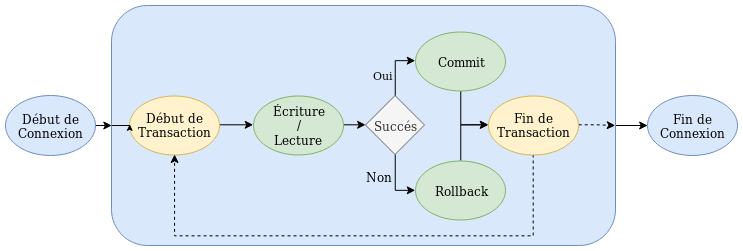

Point important :
- Durant une connexion, plusieurs transactions peuvent avoir lieu.
- Une transaction peut contenir une ou plusieurs requêtes
- Une transaction peut être intégralement annulée, ce qui a pour effet d'annuler l'ensemble des requêtes (et donc des INSERT et UPDATE).

### Important !

Quand vous entreprendrez vos propres projets et que vous travaillerez avec des bases de données:

1. Ne jamais travailler directement sur la base de données publique : une erreur est vite arrivée et vous ne voulez pas effacer l'ensemble des données par mégarde...
2. Travaillez sur des copies : faites un backup et installez ces données sur votre propre machine
3. Privilégiez le lancement de toutes vos requêtes sur des machines hors production (= celles qui ne sont pas utilisées par le public) avant de les faire fonctionner réellement.

### MySQL et Python

Nous ne couvrons plus ici l'utilisation de MySQL et python de manière brute. Pour plus d'information, vous pouvez aller voir le cour dans sa forme de [2017-2018](https://github.com/PonteIneptique/cours-python/releases/tag/2017-2018).

### Installation SQLite

**Normalement, SQLite vient avec Mac et Linux Ubuntu par défaut.**

Sinon : 

#### Ubuntu

```shell
sudo apt-get install sqlite3
```

#### Mac

Installez [homebrew](https://brew.sh/index_fr) puis :

```shell
brew install sqlite3
```

## SQLAlchemy et Flask_sqlalchemy

Pour interagir avec des bases de données SQL, nous recommandons en général l'utilisation de SQLAlchemy et de son adaptation à Flask `flask_sqlalchemy`. Nous ne verrons pas l'intégralité des possibilités de SQLAlchemy pour le moment mais simplement l'utilisation de celui-ci pour interroger une base de données existante.

Pour installer le package, nous allons utiliser `pip` et taper dans notre terminal, avec l'environnement virtuel installé, `pip install flask_sqlalchemy==2.3.2` : 

In [ ]:
!pip install flask_sqlalchemy==2.3.2

Pour utiliser flask-sqlalchemy, il va falloir connecter notre application à la base de données. Pour ce faire, il faut donner à configurer Sql Alchemy : 

```python
from flask import Flask
from flask_sqlalchemy import SQLAlchemy

app = Flask("Nom")
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///cours-flask/db.sqlite'
db = SQLAlchemy(app)
```

### Commentaire de code :

- Nous importons à la fois Flask et SQLAlchemy (Version flask_sqlalchemy)
- Nous créons une application Flask qui portera le nom "Nom"
- Nous configurons l'application avec les informations nécessaires pour se connecter. Vous trouverez l'ensemble des informations dans la partie [configuration](http://flask-sqlalchemy.pocoo.org/2.3/config/) de la documentation de Flask_SQLAlchemy
- Nous initions l'objet SQLAlchemy en lui fournissant l'application comme variable et en le stockant dans la variable `db`.
- L'adresse de base de données est composée de :
    - `sqlite://` qui indique le moteur utilisé
    - `/` qui indique pour sqlite l'usage d'un chemin relatif (un chemin absolu est précédé de `//` pour sqlite)
    - `cours-flask/db.sqlite` le chemin depuis la racine du cours python jusqu'à la base de données

Vu que nous n'exécutons pas le code pour le moment, vous pouvez lancer le code suivant :

In [ ]:
from flask import Flask
from flask_sqlalchemy import SQLAlchemy

app = Flask("Nom")
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///cours-flask/db.sqlite'
db = SQLAlchemy(app)

**Important:** Vous avez sûrement un avertissement. La documentation de flask_sqlalchemy nous informe que le paramètre `SQLALCHEMY_TRACK_MODIFICATIONS` devrait être désactivé, car il provoque des baisses de performances et qu'il sera supprimé par défaut dans le futur. Nous le conserverons ainsi pour le moment bien que nous ne l'utiliserons pas.

### Les requêtes manuelles

Pour récupérer des données de la table `place` avec SQLAlchemy, il suffit d'exécuter la sous-méthode `engine.execute()` de `db`:

In [ ]:
query = db.engine.execute("SELECT * FROM place")
print(query)
# Vous pouvez remplacer fetchmany par fetchall ou fetchone en supprimant le 2
for x in query.fetchmany(2):
    print(x["place_nom"])
    print(type(x))

Plusieurs choses nous intéressent ici :
- Notre variable `query` est en fait un objet `ResultProxy` qui possèdent diverses méthodes comme `.fetchone()`, `.fetchall()` et `.fetchmany(nombre)`.
- Nous pouvons faire une boucle sur le résultat des méthodes `.fetch[COMBIEN]()`
- Nos résultats sont en fait des objets `RowProxy` se comportant aussi comme des dictionnaires.
- Nos résultats prennent comme clé de dictionnaire les noms des colonnes

Cependant, peu de développeurs utilisent SQLAlchemy et sa version Flask pour écrire ce genre de requête...

### Générer les requêtes automatiquement : les modèles

De fait, il est plus courant pour les développeur-se-s utilisant SQLAlchemy de créer ce que l'on va appeler des modèles. Les modèles sont créés grâce à la déclaration `class` comme suit :

```python
class Place(db.Model):
    # Tout comme tous les deux points de python, on écrit ensuite en décalé
```

Le nom de la après `class` doit être le même que le nom de la table (avec une majuscule pour l'identifier visuellement plus facilement). On enregistre ensuite les différents champs du modèle avec la syntaxe `nom = colonne(type de colonne, paramètres supplémentaires)`:

```python
class Place(db.Model):
    place_id = db.Column(db.Integer, unique=True, nullable=False, primary_key=True, autoincrement=True)
```

Il existe alors plusieurs types de colonnes :

| Type         | Exemple         | Définition                                                                    |
| ------------ | --------------- | ------------------------------------------------------------------------------|
| Entier       | db.Integer      | Stocke un entier                                                              |
| Chaîne       | db.String(42)   | Stocke une chaîne à taille maximale ( ici 42)                                 |
| Texte        | db.Text         | Un texte sans taille maximale                                                 |
| DateTime     | db.DateTime     | Date et Heure suivant un objet [`datetime`](https://docs.python.org/3.5/library/datetime.html) en python                           |
| Float        | db.Float        | Stocke un décimal                                                             |
| Boolean      | db.Boolean      | Stocke un booléen                                                             |

![Modele pour les images](images/model.place.png)

Pour notre classe modèle dont nous recopions l'image ci-dessus, cela signifie que notre code sera :

In [ ]:
class Place(db.Model):
    place_id = db.Column(db.Integer, unique=True, nullable=False, primary_key=True, autoincrement=True)
    place_nom = db.Column(db.Text)
    place_description = db.Column(db.Text)
    place_longitude = db.Column(db.Float)
    place_latitude = db.Column(db.Float)
    place_type = db.Column(db.String(45))

#### Exercice

Réalisez la même chose pour la table utilisateur :

![User Model](images/model.user.png)

In [ ]:
# Votre code ici


### Des modèles aux requêtes

#### `Select * From Place`
Maintenant que notre modèle est mis en place, il est possible de faire des requêtes. Pour récupérer l'intégralité des lieux, nous devons faire `NomDeLaClasseDeDonnées.query.all()`

In [ ]:
lieux = Place.query.all()
print(lieux)

#### Afficher des informations sur un lieu

Nous avons donc désormais une liste de lieux issus de la base de données. Peut-être pouvons-nous afficher le nom de chacun d'entre eux. Pour cela, nous allons utiliser les noms de colonnes comme des attributs :

In [ ]:
for lieu in lieux:
    print(lieu.place_nom, lieu.place_type)

#### `Select * From Places where place_id = 1`

Pour les clés primaires, Flask SqlAlchemy propose l'utilisation de `.query.get(cle)` pour récupérer l'information, en l'occurrence, si l'on voulait retrouver le lieu 5 :

In [ ]:
cinq = Place.query.get(5)
print(cinq.place_nom)

#### `Select * From Places where place_type="settlement"`

Pour les requêtes plus complexes (avec un champ autre que le champ primaire), on utilise les conditions pythons `==` dans `.query.filter()`. On retrouve ensuite les résultats en utilisant :


In [ ]:
settlements = Place.query.filter(Place.place_type=="settlement").all()
print(settlements)

#### Compter le nombre de résultats

Il y a des situations où l'on souhaite simplement compter les résultats pour afficher cette information. On remplacera alors simplement `.all()` par `.count()` :


In [ ]:
settlements = Place.query.filter(Place.place_type=="settlement").count()
print(settlements)

### Une expliquation : ce qui se passe derrière tout cela

SQL Alchemy est ce que l'on appelle un ORM ([Object-Relational Mapping](https://fr.wikipedia.org/wiki/Mapping_objet-relationnel)). Les ORM ont généralement plusieurs avantages sur l'utilisation de requêtes directement écrites en SQL :

- les résultats sont dans des formes faciles à exploiter : il ne s'agit pas de dictionnaire ou de liste, mais d'objet;
- les requêtes sont simples à écrire et faciles à comprendre sans avoir de grandes connaissances en SQL;
- généralement, ils offrent une compatibilité avec de nombreux systèmes : SQLAlchemy peut se connecter à SQLite, Postgresql, MySQL, Oracle, MS-SQL, Firebird, Sybase, etc. Cela signifie qu'il est possible de changer de système très facilement en changeant simplement la ligne de connexion.

Quand on réalise une requête de type `Place.query.filter(Place.place_type=="settlement")`, Flask-SQLAlchemy va commencer à construire la requête suivante : `SELECT * FROM Place WHERE place_type="settlement"`. Puis, :
- en faisant `.all()` ensuite, il va récupérer l'ensemble des résultats tels quels
- en faisant `.count()`, il va modifier la requête en `SELECT COUNT(*) FROM Place where place_type="settlement"` puis l'exécuter
- en faisant `.first()`, on récupèrera le premier résultat (et donc on évite une liste)

La requête est donc traduite et augmentée au fur et à mesure que nous enchaînons les méthodes.

#### Exercice
Par exemple, on peut très bien ordonner les objets. Pouvez-vous traduire la ligne suivante en MySQL :

In [ ]:
settlements = Place.query.filter(Place.place_type=="settlement").order_by(Place.place_nom.desc()).all()
print(settlements)

# En SQL :
requete = ""

Notez qu'il est possible de récupérer la requête traduire pour la déboguer !

In [ ]:
requete = Place.query.filter(Place.place_type=="settlement").order_by(Place.place_nom.desc())

# En SQL :
print(requete)

### Des requêtes à leur utilisation dans une page web

Maintenant que nous avons notre modèle, nous pouvons commencer à intégrer ces requêtes. Nous avions jusque là une page index qui affichait l'ensemble des liens de la base de données. Nous allons donc d'abord configurer comme ci-dessus Flask SQL Alchemy :

```python

from flask import Flask, render_template
from flask_sqlalchemy import SQLAlchemy

app = Flask("Application")
# On configure la base de données
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///cours-flask/db.sqlite'
# On initie l'extension
db = SQLAlchemy(app)
```

On copiera ensuite le modèle de données :

```python

class Place(db.Model):
    place_id = db.Column(db.Integer, unique=True, nullable=False, primary_key=True, autoincrement=True)
    place_nom = db.Column(db.Text)
    place_description = db.Column(db.Text)
    place_longitude = db.Column(db.Float)
    place_latitude = db.Column(db.Float)
    place_type = db.Column(db.String(45))
```

Puis on récupère les données au moment de l'exécution des routes :

```python

@app.route("/")
def accueil():
    # On a bien sûr aussi modifié le template pour refléter le changement
    lieux = Place.query.all()
    return render_template("pages/accueil.html", nom="Gazetteer", lieux=lieux)
```


#### Exercice

**Avant de regarder l'exemple 11 ci-dessous**, essayez de modifier la route ci-dessous afin qu'elle utilise la connexion à la base de données :

```python
@app.route("/place/<int:place_id>")
def lieu(place_id):
    return render_template("pages/place.html", nom="Gazetteer", lieu=lieux[place_id])
```

In [ ]:
# Votre code ici :

#### Exemple 11

- [Nouveau template pour l'accueil](cours-flask/exemple11/templates/pages/accueil.html)
- [Nouveau template pour les lieux](cours-flask/exemple11/templates/pages/place.html)

Dans votre terminal, avec votre environnement virtuel :

```sh
cd cours-flask/exemple11
python app.py
```

puis allez sur http://127.0.0.1:5000